In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
# import three used BioPython packages
from Bio import SeqIO
from Bio import AlignIO
from Bio import Phylo

In [3]:
def split_string(s):
    return (''.join(c for c in s if c.isdigit()) or None, 
        ''.join(c for c in s if c.isalpha()) or None)

In [4]:
species = {'alpha01': [32, 42],
           'alpha02': [3, 10, 28, 29],
           'alpha03': [61],
           'alpha04': [2, 27, 57],
           'alpha05': [51, 69],
           'alpha06': [56],
           'alpha07': [18, 39, 45, 59, 68, 70],
           'alpha08': [7],
           'alpha09': [16, 31, 33, 35, 52, 58, 67],
           'alpha11': [34],
           'alpha13': [54],
           'beta1': [5, 8, 12, 14, 19, 20, 21, 24, 25, 36, 47, 93], 
           'beta2': [9, 15, 17, 22, 23, 37, 38, 80, 100, 151],
           'beta3': [49, 75, 76], 
           'beta4': [92],
           'beta5': [96],
           'gamma01': [4, 65, 95], 
           'gamma02': [48],
           'gamma03': [50],
           'gamma04': [60],
           'gamma05': [88],
           'gamma12': [132],
           'gamma24': [197],
           'mu': [1],
           'nu': [41],
}

inverted_dict = {}
for specy, types in species.items():
    for typ in types:
        inverted_dict[typ] = specy
        
inverted_dict = {'HPV' + str(i): inverted_dict[i] for i in sorted(inverted_dict.keys())}

In [5]:
# assign directory
directory = '../data_viruses'
 
# iterate over files in
temp_list = []
# iterate over files in the directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
#     print(f)
    # take the sequence from the genbank file (should be just 1 always i believe)
    t = SeqIO.read(f, "genbank")
    t.name = t.name[:-3]
    t.id = t.name
    temp_list.append(t)

# Combine all of the individual sequences into a new file 
_ = SeqIO.write(temp_list, "../data_extracted/hpvs.fasta", "fasta")

In [6]:
# Load the turtles sequences into MUSCLE 
# https://www.ebi.ac.uk/Tools/msa/muscle/
# Save the new alignment file as ../data_extracted/dna_alignment.aln
# https://www.ebi.ac.uk/Tools/services/web/toolresult.ebi?jobId=muscle-I20220130-002724-0698-25853659-p1m

In [7]:
# Open the alignment file as a MultipleSeqAlignment object 
with open("../data_extracted/dna_alignment.aln","r") as aln: 
    alignment = AlignIO.read(aln,"clustal")

In [8]:
from Bio.Phylo.TreeConstruction import DistanceCalculator 
calculator = DistanceCalculator('identity')

distance_matrix = calculator.get_distance(alignment);

from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor(calculator)

turtle_tree = constructor.build_tree(alignment)
turtle_tree.rooted = True
print(turtle_tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner65')
        Clade(branch_length=7.575134727997104e-05, name='Inner64')
            Clade(branch_length=0.0085453984288806, name='Inner62')
                Clade(branch_length=0.00924627191899214, name='Inner60')
                    Clade(branch_length=0.028523709494854, name='Inner50')
                        Clade(branch_length=0.0019751429547683053, name='Inner49')
                            Clade(branch_length=0.0403849510349297, name='Inner9')
                                Clade(branch_length=0.08829811310079505, name='HPV18')
                                Clade(branch_length=0.08695436928908873, name='HPV45')
                            Clade(branch_length=0.13193958431260486, name='HPV59')
                        Clade(branch_length=0.034836365150128584, name='Inner12')
                            Clade(branch_length=0.003342562731618981, name='Inner11')
                                Clade(branch_length=0.09005558855

In [9]:
# Save the tree to a new file 
Phylo.write(turtle_tree, "../results/phylogenetic_tree.xml", "phyloxml")
Phylo.write(turtle_tree, "../results/phylogenetic_tree.nh", "newick")

1

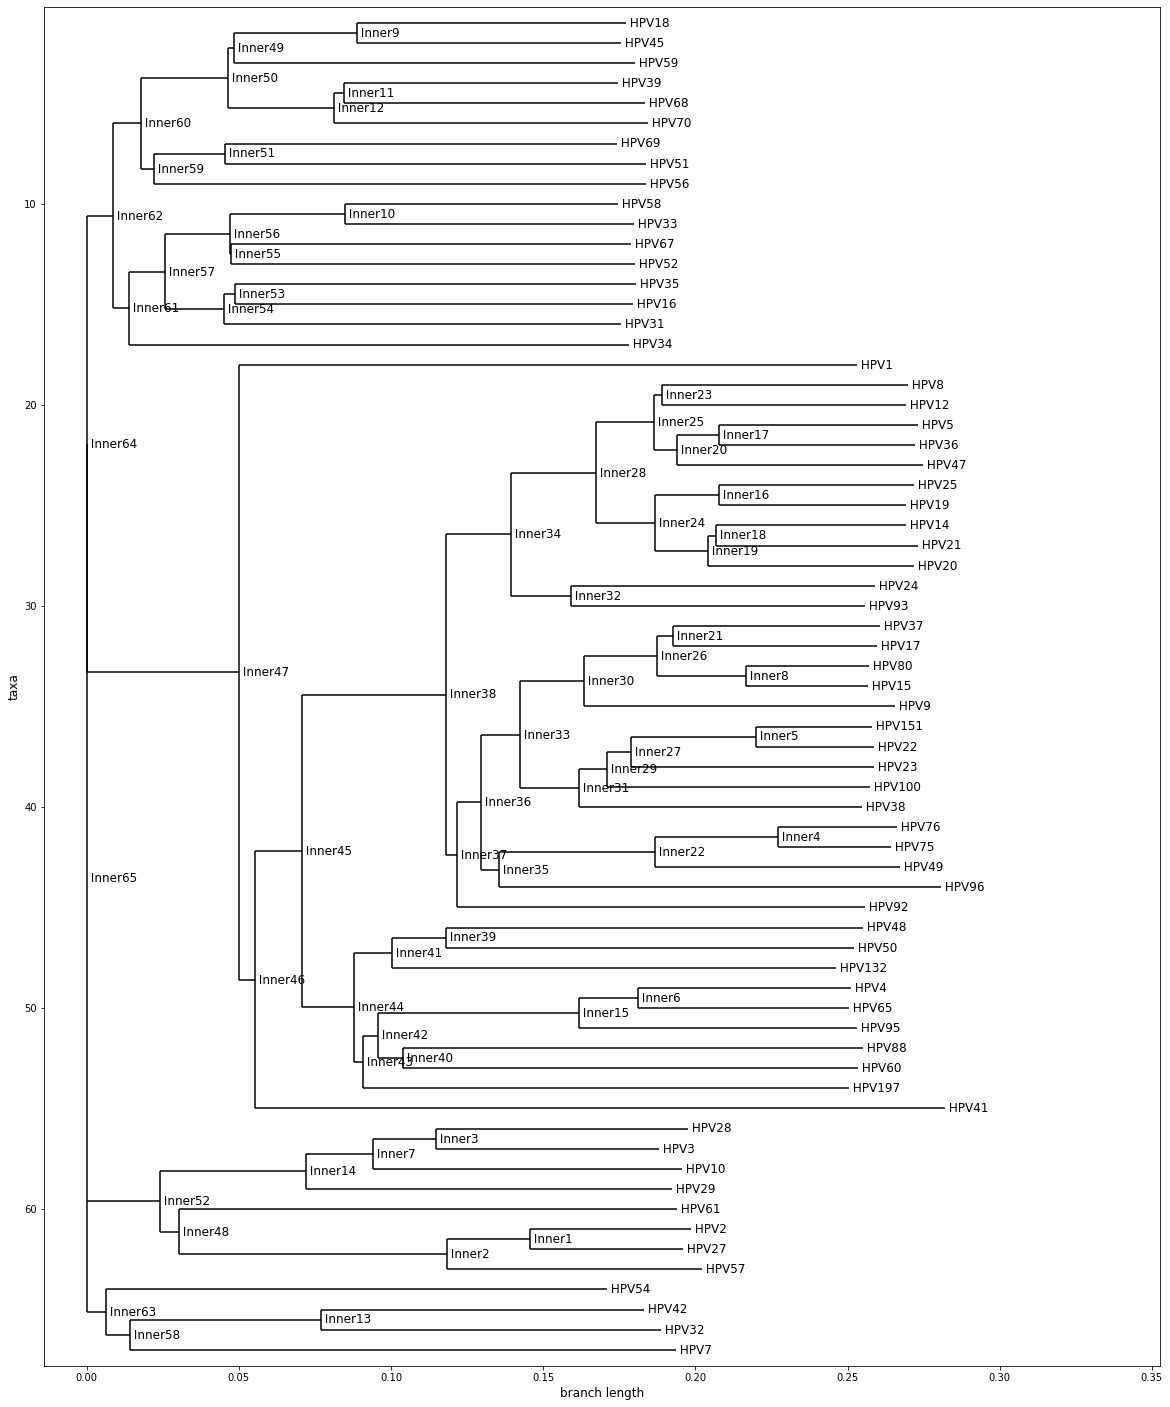

In [10]:
import matplotlib
fig = plt.figure(figsize=(20, 25)) # create figure & set the size 
matplotlib.rc('font', size=12)              # fontsize of the leaf and node labels 
matplotlib.rc('xtick', labelsize=10)       # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=10)       # fontsize of the tick labels
#turtle_tree.ladderize()
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(turtle_tree, axes=axes)
# fig.savefig("../figures/hpv_cladogram.png")

In [11]:
from ete3 import Tree
# Load a tree structure from a newick file.
t = Tree("../results/phylogenetic_tree.nh", format=1)

In [12]:
from ete3 import TreeStyle
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = True
# ts.draw_guiding_lines = True

In [13]:
# t.render('../figures/phylo_tree_ete_original.png', w=1000, units="px", tree_style=ts);

In [14]:
for leaf in t.traverse(strategy='postorder'):
    if leaf.name[:3] == 'HPV':
        leaf.name = inverted_dict[leaf.name] + '_' + leaf.name
    if leaf.name[:5] == 'Inner':
        leaf.sort_descendants()
        leaf.name = leaf.children[0].name.split('_')[0]

In [15]:
for leaf in t.traverse(strategy='postorder'):
    if 'HPV' in leaf.name:
        leaf.name = ' ' + leaf.name.split('_')[1] + ' (' + leaf.name.split('_')[0] + ')'

t.render('../figures/phylo_tree_ete_sorted_with_species.png', w=1000, units="px", tree_style=ts);

for leaf in t.traverse(strategy='postorder'):
    if 'HPV' in leaf.name:
        leaf.name = leaf.name.split(' ')[1]

# t.render('../figures/phylo_tree_ete_sorted_without_species.png', w=1000, units="px", tree_style=ts);

In [16]:
for leaf in t.traverse(strategy='preorder'):
    if leaf.get_ancestors() == []:
        leaf.add_features(total_distance = leaf.dist)
    else:
        leaf.add_features(total_distance = leaf.get_ancestors()[0].total_distance + leaf.dist)

In [17]:
# remember distances while we can
nodelist = []
temp_results = {}
for leaf in t.traverse():
    if 'HPV' in leaf.name:
        nodelist.append(leaf.name)
        temp_results[leaf.name] = leaf.total_distance
temp_results;

In [18]:
# We can also write into a file
t.write(format=1, outfile="../results/phylogenetic_tree_modified.nw")

In [19]:
# analysis starting her

In [20]:
df = pd.read_csv('../results/immunogenicity_counts_1.csv')

df['phylo distance'] = df['virus'].map(temp_results)

df[['num_species', 'let_species']] = np.concatenate(
[[i[0], i[1]] for i in df.species.apply(split_string)]).reshape(-1, 2)
df['num_species'] = df['num_species'].fillna(' ')
df

,Unnamed: 0,virus,species,immunogenicity_count_1,phylo distance,num_species,let_species
0,0,HPV41,nu,211,0.28207,,nu
1,1,HPV132,gamma12,211,0.24622,12,gamma
2,2,HPV21,beta1,210,0.27317,1,beta
3,3,HPV48,gamma2,209,0.25498,2,gamma
4,4,HPV60,gamma4,209,0.25347,4,gamma
...,...,...,...,...,...,...,...
62,62,HPV33,alpha9,154,0.17996,9,alpha
63,63,HPV3,alpha2,153,0.18800,2,alpha
64,64,HPV32,alpha1,153,0.18881,1,alpha
65,65,HPV54,alpha13,151,0.17096,13,alpha


In [21]:
df['relevance'] = 0
for row in df.iterrows():
    relevance = row[1].let_species if row[1].let_species in ['alpha', 'nu', 'mu'] else 0
    relevance = (row[1].let_species + '\ (other)') if row[1].let_species in ['beta', 'gamma'] else relevance
    relevance = row[1].species if row[1].species in ['beta1', 'beta2', 'beta3', 'gamma1'] else relevance
    df['relevance'].iloc[row[0]] = relevance
df.head()

/Users/antonalyakin/.virtualenvs/graphs/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Unnamed: 0,virus,species,immunogenicity_count_1,phylo distance,num_species,let_species,relevance
0,0,HPV41,nu,211,0.28207,,nu,nu
1,1,HPV132,gamma12,211,0.24622,12,gamma,gamma\ (other)
2,2,HPV21,beta1,210,0.27317,1,beta,beta1
3,3,HPV48,gamma2,209,0.25498,2,gamma,gamma\ (other)
4,4,HPV60,gamma4,209,0.25347,4,gamma,gamma\ (other)


In [22]:
# df['species'] = ' $\\' + df['let_species'] + ' ' + df['num_species'] + '$'

/Users/antonalyakin/.virtualenvs/graphs/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  after removing the cwd from sys.path.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


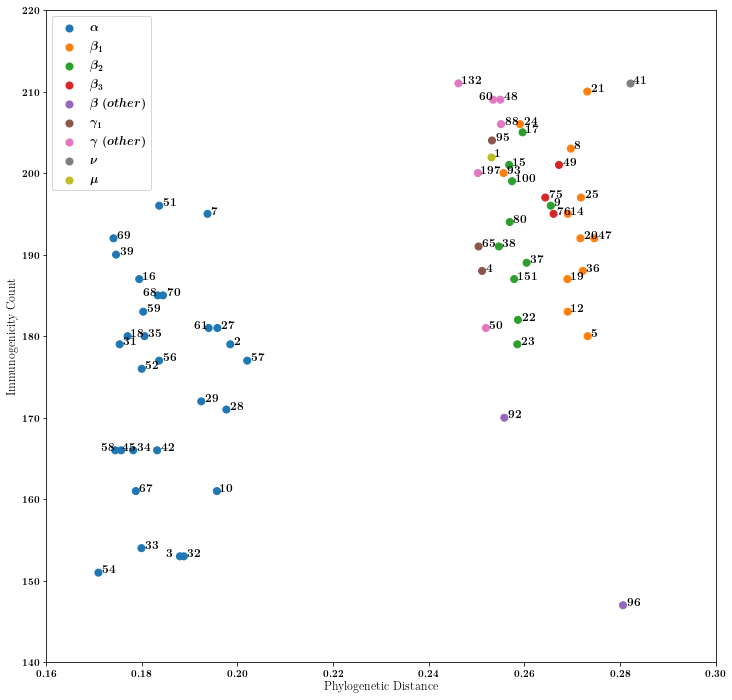

In [23]:
# plt.rcParams['text.usetex'] = True
matplotlib.rc('font', family='serif', serif='cm10')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')

for relevance in ['alpha', 'beta1', 'beta2', 'beta3', 'beta\ (other)',
                  'gamma1', 'gamma\ (other)', 'nu', 'mu']:
    temp = df[df.relevance == relevance]
    x = temp['phylo distance'].values
    y = temp['immunogenicity_count_1'].values
    s = [50] * len(x)
    label = '$$\\' + relevance.replace('1', '_1').replace('2', '_2').replace('3', '_3') + '$$'
    ax.scatter(x, y, label=label, s=s)
    for i, txt in enumerate(temp.virus.values):
        if txt in ['HPV3', 'HPV58', 'HPV60', 'HPV61', 'HPV68']:
            ax.annotate('$$' + txt[3:] + '$$',
                        (x[i]-0.00300, y[i]+0.00075), fontsize=12)
        elif txt in ['HPV45']:
            ax.annotate('$$' + txt[3:] + '$$',
                        (x[i]+0.00025, y[i]+0.00150), fontsize=12)
        else:
            ax.annotate('$$' + txt[3:] + '$$',
                        (x[i]+0.00075, y[i]+0.00075), fontsize=12)
            
# from scipy.stats import linregress
# X = df['phylo distance'].values
# Y = df['immunogenicity_count_1'].values
# lr = linregress(X, Y)
# ax.plot([0.165, 0.295],
#          [lr.intercept + lr.slope*0.16, lr.intercept + lr.slope*0.30],
#          '--', color='k', linewidth=1,
#         label = 'linear fit' )

ax.set_xlim([0.16, 0.30])
ax.set_ylim([140, 220])
ax.set_xlabel('Phylogenetic Distance')
ax.set_ylabel('Immunogenicity Count')
ax.legend()

plt.savefig('../figures/immunogenicity_vs_phylodistance.png',
            dpi=300,
            bbox_inches='tight')

In [24]:
X = df['phylo distance'].values
y = df['immunogenicity_count_1'].values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     31.96
Date:                Thu, 28 Mar 2024   Prob (F-statistic):           3.78e-07
Time:                        19:00:49   Log-Likelihood:                -267.07
No. Observations:                  67   AIC:                             538.1
Df Residuals:                      65   BIC:                             542.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        132.7740      9.498     13.979      0.0

In [26]:
label = (df['let_species'] == 'alpha').values
is_alpha = y[label]
not_alpha = y[~label]
is_alpha, not_alpha

(array([196, 195, 192, 190, 187, 185, 185, 183, 181, 181, 180, 180, 179,
        179, 177, 177, 176, 172, 171, 166, 166, 166, 166, 161, 161, 154,
        153, 153, 151]),
 array([211, 211, 210, 209, 209, 206, 206, 205, 204, 203, 202, 201, 201,
        200, 200, 199, 197, 197, 196, 195, 195, 194, 192, 192, 191, 191,
        189, 188, 188, 187, 187, 183, 182, 181, 180, 179, 170, 147]))

In [27]:
stats.ttest_ind(is_alpha, not_alpha)

Ttest_indResult(statistic=-6.196928888033905, pvalue=4.4262317267203413e-08)

In [28]:
stats.ranksums(is_alpha, not_alpha)

RanksumsResult(statistic=-5.276931108290102, pvalue=1.313652430246841e-07)

In [29]:
# import dcor
# dcor.homogeneity.energy_test(
#     is_alpha,
#     not_alpha,
#     num_resamples=200,)

HypothesisTest(p_value=0.004975124378109453, statistic=279.3021643145434)

In [30]:
lm = LinearRegression()
lm.fit(X.reshape(-1, 1),y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X.reshape(-1, 1))

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

   Coefficients  Standard Errors  t values  Probabilities
0      132.7740            9.498    13.979            NaN
1      231.7619           40.995     5.653            NaN


In [31]:
# ultrametric tree + immunocounts

In [32]:
#Convert to ultrametric
# prevent using labels and symbols in internal nodes
for n in t.traverse():
    n.img_style["size"] = 0
    n.img_style["vt_line_width"] = 0

#Convert to ultrametric
most_distant_leaf, tree_length = t.get_farthest_leaf()
current_dist = 0
for postorder, node in t.iter_prepostorder():
    if postorder:
        current_dist -= node.dist
    else:
        if node.is_leaf():
            node.dist += tree_length - (current_dist + node.dist)
#             node.name = inverted_dict[leaf.name] + '_' + leaf.name
        elif node.up: # node is internal
            current_dist += node.dist

for leaf in t.traverse(strategy='postorder'):
    if leaf.name[:3] == 'HPV':
        leaf.name = inverted_dict[leaf.name] + '_' + leaf.name
        leaf.name = ' ' + leaf.name.split('_')[1] + str(
            ' ' * (2 * (7 - len(leaf.name.split('_')[1])) - 1)) + '(' + leaf.name.split('_')[0] + ')'
        leaf.name = leaf.name.replace('a0', 'a')
        leaf.name = leaf.name.replace('alpha', 'alpha ')
        leaf.name = leaf.name.replace('beta', 'beta ')
        leaf.name = leaf.name.replace('gamma', 'gamma ')
    
t.render("../figures/left_side_ultrametric_tree.png", w=1000, units="px",);

In [33]:
temp = []
for i in nodelist:
    temp.append(df[df.virus == i])
heatmap_df = pd.concat(temp)[['virus', 'immunogenicity_count_1']]
heatmap_df

,virus,immunogenicity_count_1
65,HPV54,151
21,HPV7,195
53,HPV29,172
41,HPV61,181
10,HPV1,202
...,...,...
23,HPV80,194
7,HPV17,205
30,HPV37,189
33,HPV151,187


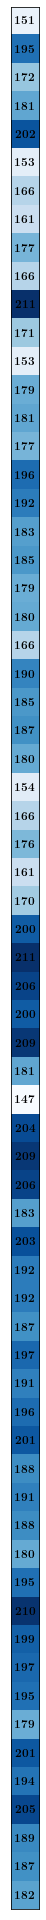

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(1, 35))
plt.imshow(heatmap_df.immunogenicity_count_1.values.reshape(-1, 1),
           cmap='Blues')
plt.xticks([])
plt.yticks([])
for i, label in enumerate(heatmap_df.immunogenicity_count_1.values):
    ax.text(0, i, '$$' + str(label) + '$$', ha='center',va='center', weight='bold')
fig.savefig('../figures/right_side.png', bbox_inches='tight', dpi=720)
# fig.savefig